<div style="border:5px solid #d3d3d3; border-radius:12px; text-align:center; padding:30px; background: linear-gradient(to right, #e0f7fa, #cce0ff); box-shadow: 2px 2px 12px rgba(0,0,0,0.1); font-family: 'Segoe UI', sans-serif;">
  <h1 style="font-weight:bold; color:#005577;">Gearing Up for Future Buys: Understanding Used Car Market Dynamics</h1>
</div>


---

### Installing required libraries

In [1]:
%pip install nbformat plotly

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas numpy seaborn matplotlib scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder


### Dataset URL from the IBM Data Science PC lab

The dataset can be found here: 

"https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0271EN-SkillsNetwork/labs/v1/m3/data/used_car_price_analysis.csv"

------------------------------------------


#### Uploading the dataset from device


Downloading the dataset directly with Pyodide or Requests was not feasible because of proxy issues.


Alternatively, I clicked the link and downloaded the file on my device. Then, I uploaded the CSV file by dragging it directly into my working directory, from a window to another. Or, simply click the Upload Files icon at the top left :)

In [4]:
import os
# This shows current working directory to read the csv file correctly
print(os.getcwd())  

/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/My Projects/Used Car Analysis


In [5]:
# Load dataset
df = pd.read_csv("/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/My Projects/Used Car Analysis/used_car_price_analysis.csv")

# Display first few rows
df.head()


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,Fiesta,2017,Automatic,15944,Petrol,150.0,57.7,1.0,12000
1,Focus,2018,Manual,9083,Petrol,150.0,57.7,1.0,14000
2,Focus,2017,Manual,12456,Petrol,150.0,57.7,1.0,13000
3,Fiesta,2019,Manual,10460,Petrol,145.0,40.3,1.5,17500
4,Fiesta,2019,Automatic,1482,Petrol,145.0,48.7,1.0,16500


In [6]:
# Dataset size
print('The size of the dataset:',df.shape)

The size of the dataset: (17966, 9)


---

## Data Cleaning

Let's verify missing values, and remove duplicates.

In [7]:
# Identifying columns with missing values
missing_values = df.isnull().sum()
print("Columns with missing values:\n", missing_values)


Columns with missing values:
 model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             3
mpg             0
engineSize      0
price           0
dtype: int64


To fix the 3 missing values...

In [8]:
# Convert categorical columns to NaN- Handling unknown values if possible
categorical_cols = df.select_dtypes(include=["object"]).columns
df[categorical_cols] = df[categorical_cols].replace("?", None) 

# Select only numeric columns for replacing missing values with mean
numeric_cols = df.select_dtypes(include=["number"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Remove duplicate entries
df.drop_duplicates(inplace=True)

# Display cleaned dataset
print("Cleaned DataFrame:\n", df.head())

Cleaned DataFrame:
      model  year transmission  mileage fuelType    tax   mpg  engineSize  \
0   Fiesta  2017    Automatic    15944   Petrol  150.0  57.7         1.0   
1    Focus  2018       Manual     9083   Petrol  150.0  57.7         1.0   
2    Focus  2017       Manual    12456   Petrol  150.0  57.7         1.0   
3   Fiesta  2019       Manual    10460   Petrol  145.0  40.3         1.5   
4   Fiesta  2019    Automatic     1482   Petrol  145.0  48.7         1.0   

   price  
0  12000  
1  14000  
2  13000  
3  17500  
4  16500  


In [9]:
df.isnull().sum()

model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

**No more missing values!**

In [10]:
# Glimpse of summary statistics (without the column 'year')
print('Summary Statistics:\n', df.drop(columns=['year']).describe().round(2))

Summary Statistics:
          mileage       tax       mpg  engineSize     price
count   17812.00  17812.00  17812.00    17812.00  17812.00
mean    23381.15    113.31     57.91        1.35  12269.56
std     19419.01     62.03     10.13        0.43   4736.29
min         1.00      0.00     20.80        0.00    495.00
25%     10000.00     30.00     52.30        1.00   8999.00
50%     18277.00    145.00     58.90        1.20  11288.00
75%     31098.50    145.00     65.70        1.50  15295.00
max    177644.00    580.00    201.80        5.00  54995.00


#### Mileage Feature
Approximately 23,38 miles on average is the typical vehicle usage, and the range is 1.00 to 177644 miles. High-mileage vehicles likely sell for lower prices, while lower-mileage cars may demand a premium. 25% of the cars are at 10000 miles, which is normal since the data is about used cars.

#### Tax Feature
The mean tax is 113 dollars and varies from 0 to 500 dollars. 25% of cars have taxes below 30, while 75% are taxed at $145. The variation might be explained by tax exemption for certain vehicles, or a tax policy based on **fuel emissions**. The lower the tax costs, the better it will be for buyers with constrained budgets.

#### MPG Feature
The mean MPG is approximately 57.9 miles per gallon, with a range of  20.8 to 201.8 MPG, suggesting that some vehicles are extremely fuel-efficient. Cars with higher MPG (especially hybrids/electric) could be more appealing for buyers when fuel prices go up.
 
#### Engine Size Feature
The mean of engine size is 1.35 liters, and the range is 0.0 to 5.0 liters. The 0.0 liters indicate the use of electric engines. 50% of cars have engines less than or equal to 1.2 liters, indicating that more compact models dominate the market. Larger engine vehicles, those greater or equal to 1.5 liters, suggest higher performance and are thus to be premium models.

#### Price Feature
The mean price is  12,269 dollars, and the range is 495-54,995 dollars. This large disparity might be due to different car conditions, brands, and features. 25% of vehicles, when the price is less than or equal to 8,999 dollars, suggest cheaper purchases. 75% of vehicles, when the price is greater than or equal to $15,295, indicate the premium models in the market. Being top of the quartile, the premium model dominates the lower price range.


---

 **Identifying the 5 top attributes that have the highest correlation with the price parameter.**

In [11]:
# Compute correlation matrix with only numerical colunms
correlation_matrix = df[numeric_cols].corr()

# The target attribute 
target_attribute = "price"

# Identify the top 5 attributes with highest correlation
top_attributes = correlation_matrix[target_attribute].abs().sort_values(ascending=False).index[1:6]

# Print the top 5 correlated attributes
print("Top 5 attributes with highest correlation to", target_attribute, ":\n", top_attributes)


Top 5 attributes with highest correlation to price :
 Index(['year', 'mileage', 'engineSize', 'tax', 'mpg'], dtype='object')


**Visualization of the top 5 attributes with a heatmap**

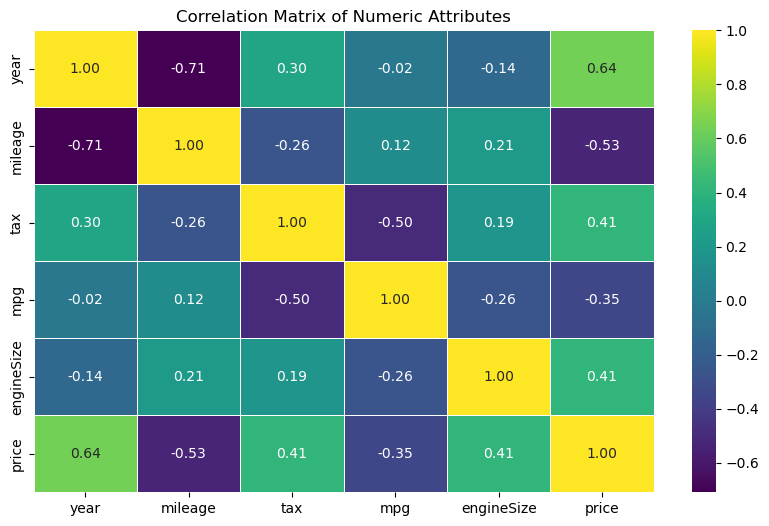

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Attributes")
plt.show()


The data indicates that year is the highest correlated feature with price. The more recent a used car is, the higher its price is.

---

## Exploratory Data Analysis

Creating a box plot with the Seaborn library to determine whether cars with automatic, manual or semi-auto type of transmission have more price outliers.

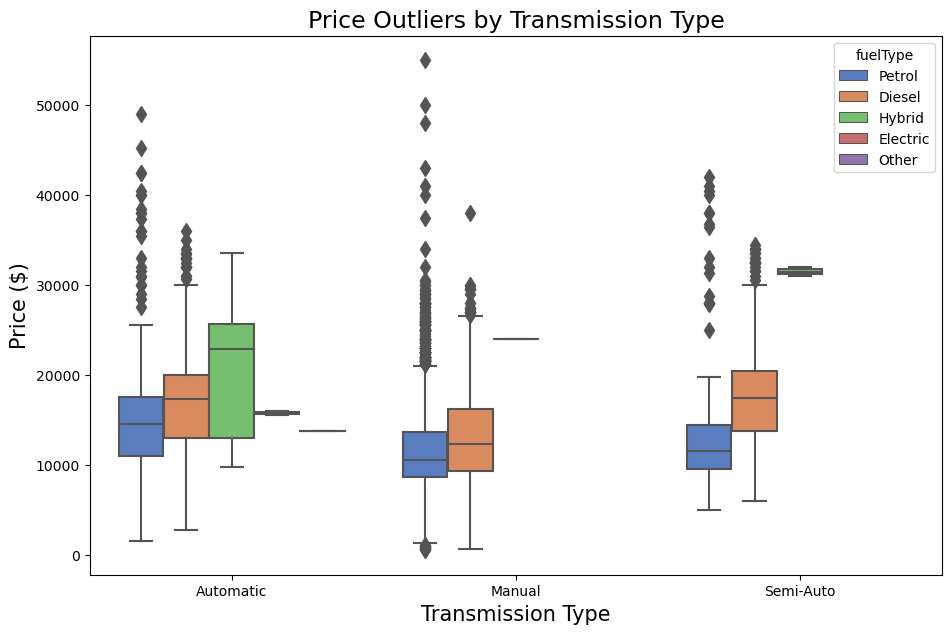

In [13]:
# Create a box plot for transmission vs. price
plt.figure(figsize=(11, 7))
sns.boxplot(x=df["transmission"], y=df["price"], palette='muted',fliersize=8, width=0.8, hue='fuelType', data=df)
plt.title("Price Outliers by Transmission Type", fontsize=17)
plt.xlabel("Transmission Type", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.show()


The boxplot suggest that manual transmission vehicles have more price outliers compared to semi-auto and automatic cars. 

##### Factors that can explain this:

1. Some manual cars are "economy" models. It often leads to low-price outliers. Other models are high-performance sports cars, contributing to high-price outliers.

2. Declining demand for manual cars and the fact that they are harder to resell may lead to variable pricing, with some sellers drastically lowering prices to attract buyers, while luxury manual cars demand premium prices.

3. Automatic cars are the Standard and more popular. Most modern cars use an automatic transmission, making their pricing more predictable and consistent than the others.

---

### Insights on the Fuel Type Feature

In [14]:
# Specifying the column fuelType
column_name = "fuelType" 

# Count the occurrences of each unique value
value_counts = df[column_name].value_counts()
print("Count of unique values in fuelType feature:\n", value_counts)


Count of unique values in fuelType feature:
 fuelType
Petrol      12081
Diesel       5706
Hybrid         22
Electric        2
Other           1
Name: count, dtype: int64


Generating a bar chart for fuelType feature.

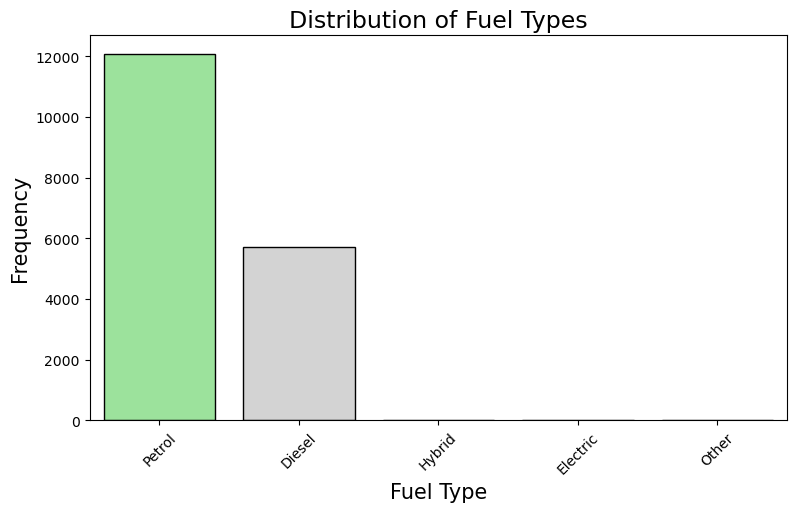

In [15]:
# Counting the fuelType feature
fuel_num = df[column_name].value_counts()

# To determine the highest count -- Useful for the loop
highest_fuel_type = fuel_num.idxmax()

# Creating the bar chart
plt.figure(figsize=(9,5))
colors = ['lightgreen' if fuel==highest_fuel_type else 'lightgrey' for fuel in fuel_num.index.tolist()]
sns.barplot(x=fuel_num.index, y=fuel_num.values, palette= colors,edgecolor='black')
plt.title('Distribution of Fuel Types', fontsize=17)
plt.xlabel('Fuel Type', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Frequency', fontsize=15)
plt.show()

#### Comments : 
1. Petrol cars dominate the market, showing strong consumer preference.
   
2. Diesel is significantly lower, but still holds a notable presence in the market in smaller quantities than Petrol vehicles.
   
3. Hybrid & Electric cars are rare and have extremely low numbers, possibly due to higher initial costs, or consumer hesitation about new technology. It indicates low demand and utility, and thus is susceptible to premium pricing.
   
4. Other fuel types suggest that their market presence is practically non-existent. 

**Based on this result, dealerships should primarily focus on selling Petrol and Diesel cars. Nevertheless, the instant the trend shifts - if fuel prices increase -  used car buyers could have more incentive to purchase Electric/Hybrid cars.**

---

### Insights on the Transmission Feature

In [16]:
# Counting the occurrences of each unique value
value_counts2 = df['transmission'].value_counts()
print("Count of unique values in transmission feature :\n", value_counts2)


Count of unique values in transmission feature :
 transmission
Manual       15383
Automatic     1354
Semi-Auto     1075
Name: count, dtype: int64


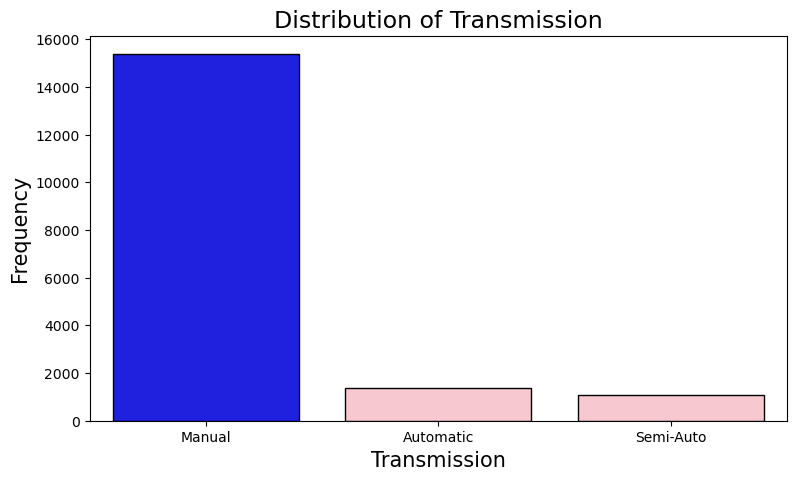

In [17]:
# To determine the highest transmission type
highest_transm_count = value_counts2.idxmax()

# Creating a list of color palette
colors2 = ['blue' if transm== highest_transm_count else 'pink' for transm in value_counts2.index]

# Creating bar plot
plt.figure(figsize=(9,5))
sns.barplot(x=value_counts2.index, y=value_counts2.values, palette= colors2,edgecolor='black')
plt.title('Distribution of Transmission', fontsize=17)
plt.xlabel('Transmission', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

#### Comments : 

1. The vast majority of used cars are manual, indicating that either manual cars are more widely available or they are preferred in the used car market.

2. Automatic cars are significantly less common, but somewhat significant. Automatic vehicles are often more expensive, which could also impact their affordability in the used car market.

3. Semi-Auto cars are the least common in the used car market because they are considered to be unique variants. Therefore, Semi-Auto cars will appeal to a smaller portion of buyers due to their specific functionality.

---

Generating a histogram of the top 10 car models in the used car market.

In [18]:
# Showing the top 10 models
top_10_models = df['model'].value_counts().head(10)
print(top_10_models)

model
 Fiesta         6509
 Focus          4555
 Kuga           2208
 EcoSport       1127
 C-MAX           542
 Ka+             523
 Mondeo          512
 B-MAX           350
 S-MAX           294
 Grand C-MAX     247
Name: count, dtype: int64


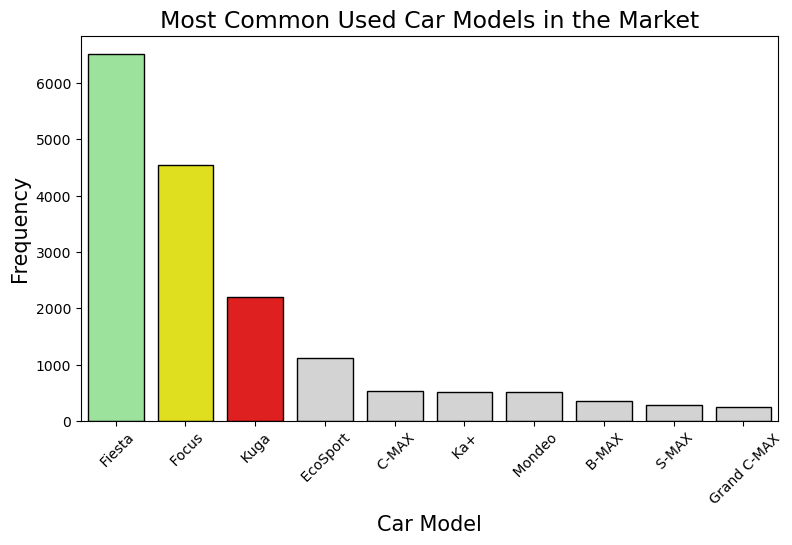

In [19]:
highest_model = top_10_models.idxmax()
second_highest_model = top_10_models.index[1]
third_highest_model = top_10_models.index[2]
colors3 = ['lightgreen' if model == highest_model else 'yellow' if model == second_highest_model else 'red' if model==third_highest_model else 'lightgrey' for model in top_10_models.index]

# Histogram showing top 10 models
plt.figure(figsize=(9, 5))
sns.barplot(x=top_10_models.index, y=top_10_models.values, palette=colors3, edgecolor='black')
plt.title("Most Common Used Car Models in the Market", fontsize=17)
plt.xticks(rotation=45)
plt.xlabel("Car Model", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()


#### Comments : 
1. We notice that the Fiesta and Focus models - *Both Compact models* - are favored in the market, likely for their efficiency. Kuga and EcoSport - *Both SUVs* - have a decent market presence, likely chosen for versatility. 
2. The difference between the other models is significant. Luxury and larger family models (Mondeo, C-MAX, etc.) exist but in smaller numbers, serving specific buyer segments.

---

Generating regression plots between mpg, engine size, mileage, tax VS price feature to determine the correlation type between them.


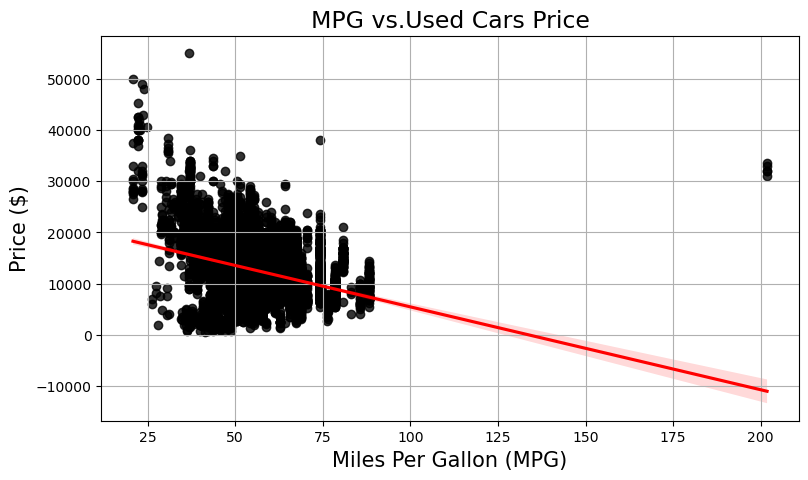

In [20]:
# Create a regression plot for mpg vs. price
plt.figure(figsize=(9, 5))
sns.regplot(x=df["mpg"], y=df["price"], scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title("MPG vs.Used Cars Price", fontsize=17)
plt.xlabel("Miles Per Gallon (MPG)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.grid(True)
plt.show()


**Negative correlation:**
The more MPG a car has, the lower its price is, on average.

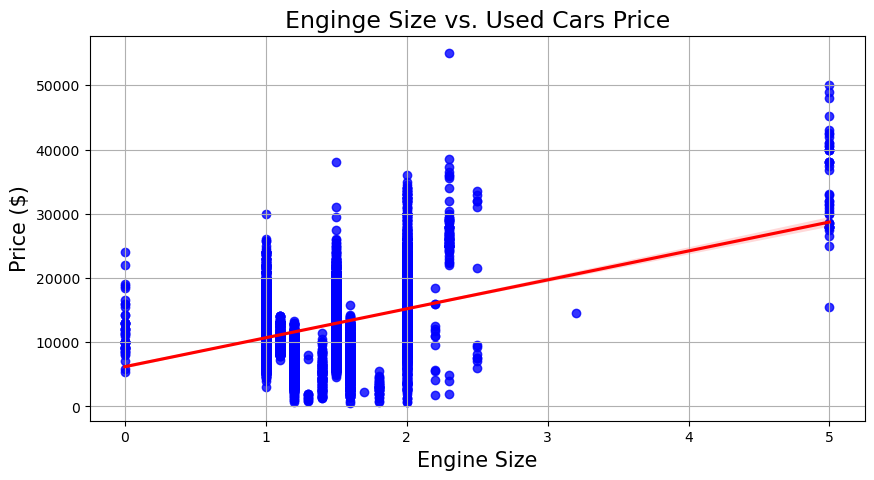

In [21]:
# Create a regression plot for engine size vs. price
plt.figure(figsize=(10, 5))
sns.regplot(x=df["engineSize"], y=df["price"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title("Enginge Size vs. Used Cars Price", fontsize=17)
plt.xlabel("Engine Size", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.grid(True)
plt.show()


**Positive correlation:** The bigger the engine size of a used car is, the more pricey that car will be, on average.

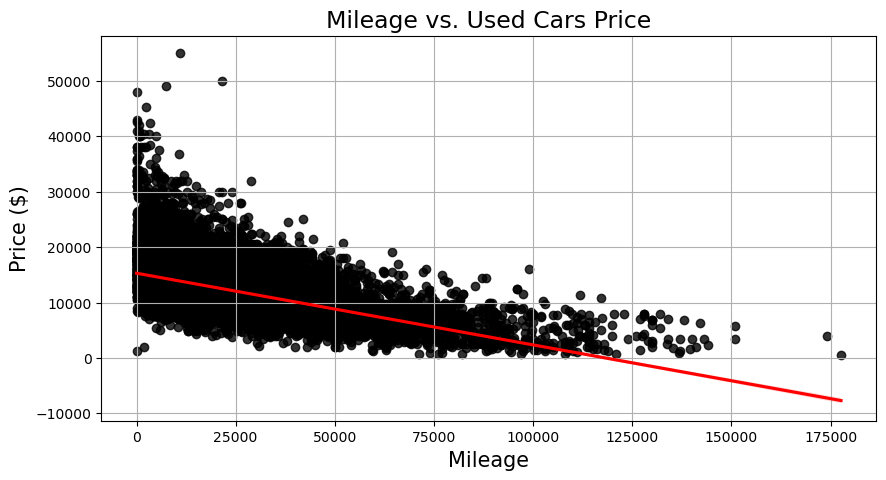

In [22]:
# Create a regression plot for mileage vs. price
plt.figure(figsize=(10, 5))
sns.regplot(x=df["mileage"], y=df["price"], scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title("Mileage vs. Used Cars Price", fontsize=17)
plt.xlabel("Mileage", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.grid(True)
plt.show()


**Negative correlation:** A higher mileage of a used car indicates that used cars are budget-friendly.

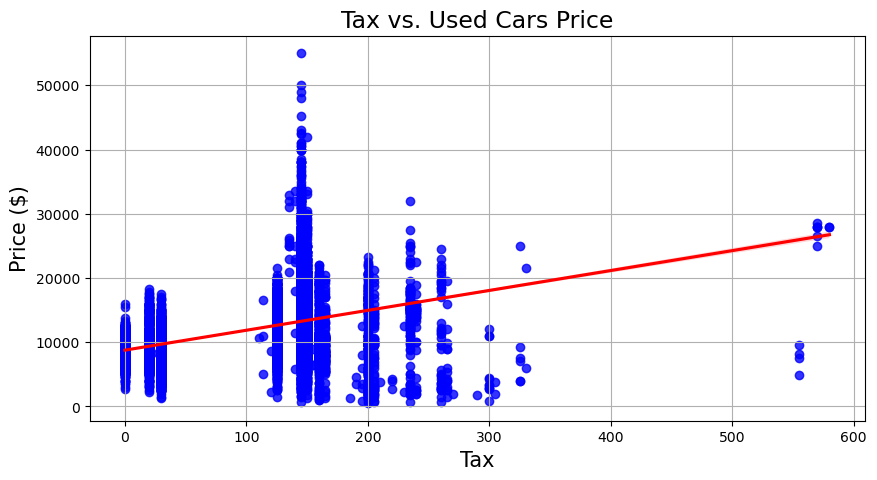

In [23]:
# Create a regression plot for tax vs. price
plt.figure(figsize=(10, 5))
sns.regplot(x=df["tax"], y=df["price"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title("Tax vs. Used Cars Price", fontsize=17)
plt.xlabel("Tax", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.grid(True)
plt.show()


**Positive correlation:** On average, as tax increases, the price of used cars also tends to rise.

## Business Implications

1. **Mileage:** Used car buyers will likely prioritize low-mileage cars, and dealerships can stock more low-mileage and budget-friendly cars to target mid-range customers, maximizing profits.

2. **Tax Impact:** In the long run, low-tax used cars are more affordable for consumers, which will constitute a strong selling point for dealerships if they proceed to stock tax-friendly used cars.
   
3. **Fuel Type:** Petrol cars dominate the market, but if fuel prices increase, consumers will shift to electric and hybrid vehicles. Also, a suggestion for dealerships is to monitor the future electric vehicles and adjust their stock accordingly.

4. **Manual vs. Automatic Transmissions:** Manual used cars are in higher demand in this market, which make them easier to resell. Manual cars dominance in the market suggests that buyers may prefer them to automatic cars, likely due to affordability issues. Dealerships should therefore prioritize stocking manual cars to meet consumers' preference/demand. 


---

# Model Development


Let' try first to fit a linear regression model to predict the price using the feature mpg. Then, calculate the R^2 and MSE values for the model.


In [24]:
# Selecting features (X) and target variable (y)
X = df[["mpg"]]  
y = df["price"] 

# Fitting a linear regression model
model = LinearRegression()
model.fit(X, y)

# Making predictions
y_pred = model.predict(X)

# Calculate R^2 and MSE
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print results
print("R^2 Score:", r2)
print("Mean Squared Error (MSE):", mse)

R^2 Score: 0.11989802249624182
Mean Squared Error (MSE): 19741690.80944619


R^2 is very low, and MSE is very high. The `MPG` predictor alone is not a good representation to explain price variations.

#### Multiple Linear Regression

In [27]:
# Adding more features for X
features = ["year", "mileage", "tax", "mpg", "engineSize"]
X = df[features]  
y = df["price"] 

#Splitting dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
#scaler = StandardScaler()
#X_train_log = scaler.fit_transform(X_train_log)
#X_test_log = scaler.transform(X_test_log)

# Fitting a linear regression model
model = LinearRegression()
model.fit(X, y)


# Make predictions
y_pred2 = model.predict(X)

# Calculate R^2 and MSE
r2 = r2_score(y, y_pred2)
mse = mean_squared_error(y, y_pred2)

print("R^2 Score:", r2)
print("Mean Squared Error (MSE):", mse)

R^2 Score: 0.7265379654546993
Mean Squared Error (MSE): 6134065.224381759


The R^2 and MSE improved significantly!!!

A R^2 score of 72.65% means that the model explains 72.65% of the variance in car prices based on the selected  features. It also suggests that about 27.35% of the price variation is unexplained by the model.

### Residual Analysis - For Multiple Linear Regression.

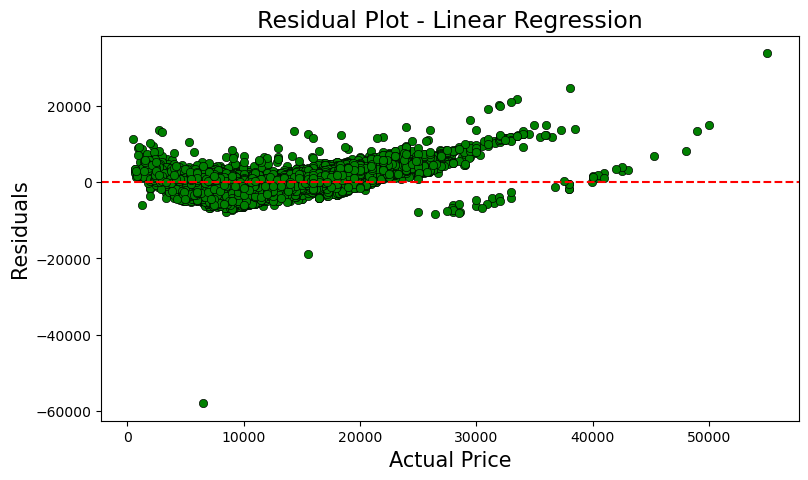

In [30]:
# Computing residuals
residuals = y - y_pred2

# Creating residual plot
plt.figure(figsize=(9, 5))
sns.scatterplot(x=y, y=residuals, color='green', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--') 
plt.title("Residual Plot - Linear Regression", fontsize=17)
plt.xlabel("Actual Price", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.show()

No strong curvature was detected and mostly scattered around the horizontal line at y = 0, suggesting the model captures general trends well. Halas, there is a **potential heteroscedasticity** (non-constant variance in errors). The reason is that the residuals appear more spread out when actual prices are high, meaning the `Multiple Linear Model` might struggle to predict higher-priced cars.

To fix this, let's apply a log transformation on the features and fit them to the model.

In [31]:
# Applying log transformation to the target variable (y)
df["log_price"] = np.log(df["price"])

# Log-transform features 
df["log_mileage"] = np.log(df["mileage"] + 1) 
df["log_engineSize"] = np.log(df["engineSize"] + 1)
df["log_tax"] = np.log(df["tax"] + 1)
df["log_mpg"] = np.log(df["mpg"] + 1)

# Selecting log-transformed features
features_log = ["year", "log_mileage", "log_tax", "log_mpg", "log_engineSize"]
X_log = df[features_log]
y_log = df["log_price"]


Fitting the log-transformed features to the Linear Regression.

In [32]:
# Splitting data
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train_log = scaler.fit_transform(X_train_log)
X_test_log = scaler.transform(X_test_log)

# Training the new linear regression model
log_model = LinearRegression()
log_model.fit(X_train_log, y_train_log)

# Making predictions
y_pred_log = log_model.predict(X_test_log)

# Evaluating performance
r2_log = r2_score(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)

print("Log-Transformed Model - R^2 Score:", round(r2_log, 4))
print("Log-Transformed Model - Mean Squared Error:", round(mse_log, 2))

Log-Transformed Model - R^2 Score: 0.6701
Log-Transformed Model - Mean Squared Error: 0.05


Replotting with log-transformation.

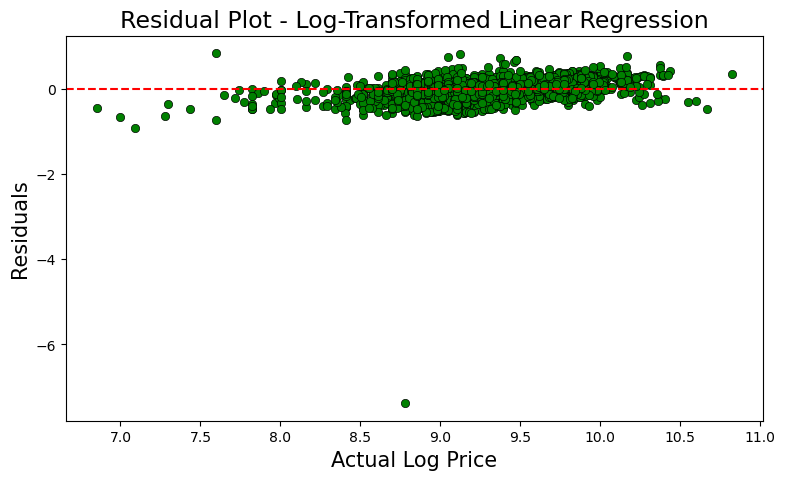

In [33]:
# Computing residuals
residuals_log = y_test_log - y_pred_log

# Plotting residuals
plt.figure(figsize=(9, 5))
sns.scatterplot(x=y_test_log, y=residuals_log, color="green", edgecolor="black")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual Plot - Log-Transformed Linear Regression", fontsize=17)
plt.xlabel("Actual Log Price", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.show()


**Much better!!!**

The residuals are more randomely scattered around 0. This reduces price variability over time and prediction bias.

Finally, let's plot a histogram showing the residuals' distribution. It is useful to evaluate how well the regression model fits the data by showing the distribution of the prediction errors.

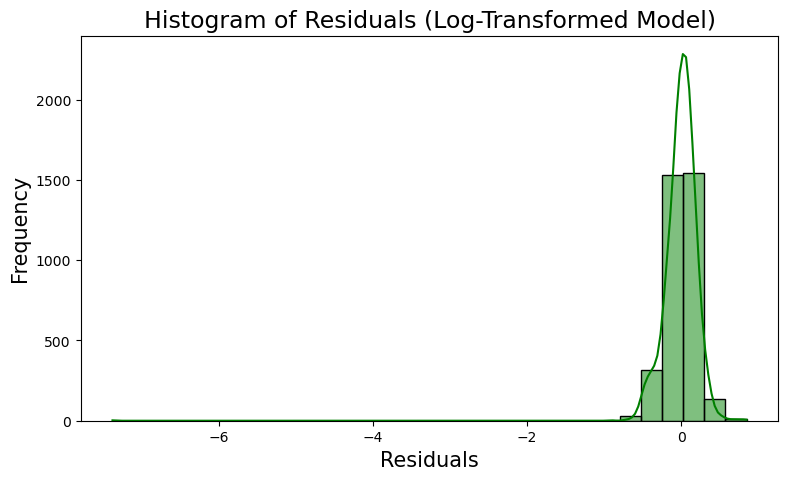

In [34]:
# Creating a histogram for residuals with Kernel Density Estimate (KDE)
plt.figure(figsize=(9, 5))
sns.histplot(residuals_log, bins=30, kde=True, color='green', edgecolor='black')

plt.title("Histogram of Residuals (Log-Transformed Model)", fontsize=17)
plt.xlabel("Residuals", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()


The residuals are mostly centered around zero, suggesting that the model makes fairly accurate predictions. Also, there is no extreme skewness, indicating minor biases in the model.

### Comment:
Although the residual plot is more centered around 0, the MSE and R^2 had they precision reduced to predict car prices. More refined models are necessary to implement here.


---

# Model Refinement

Let's try improve the model by including the encoding of the categorical features and standardizing the numerical features.

In [35]:
# including the categorical features in the X object
X = df[["year", "mileage", "tax", "mpg", "engineSize", "transmission", "fuelType"]]
y= df['price']

# Selecting categorical features
cat_feat = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Using OneHotEncoder library and creating encoder object
encoder = OneHotEncoder(drop='first', sparse=False)  

# Fitting cat_feat in the encoder object in a data frame
encoded_features = pd.DataFrame(encoder.fit_transform(X[cat_feat]), columns=encoder.get_feature_names_out(cat_feat))

# Merging encodedd features with the original DataFrame
X = X.drop(columns=cat_feat).join(encoded_features)

# Handling missing values
imputer = SimpleImputer(strategy="mean")  
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Linear Regression object and fitting the data
model2 = LinearRegression()
model2.fit(X_train, y_train)

# Making predictions
y_pred2 = model2.predict(X_test)

# Re-evaluationg model performance
r2 = r2_score(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
print('Linear Regression - The new R^2 score is:', r2)
print('Linear Regression - The new Mean Squared Error is:', mse)

Linear Regression - The new R^2 score is: 0.6945431967690754
Linear Regression - The new Mean Squared Error is: 6849274.118165651


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Comments:
One Hot Encoding of Transmission and FuelType features was supposed to enhance the model's performance; however, the results showed a slight decline in accuracy compared to the regression model without encoding. This suggests that these categorical variables may not significantly influence price prediction in the dataset. Finally, since numerical features like Year, Mileage, Engine Size, and Tax already have a stronger predictive power (72.65%), adding encoded categorical features has introduced unnecessary complexity without meaningful improvement.

## Ridge and Lasso Regression

In [36]:
# Standardizing the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit Ridge Regression with alpha=100
ridge_model = Ridge(alpha=100)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate model performance
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

# Print results
print("Ridge Regression - R^2 Score:", round(r2_ridge, 4))
print("Ridge Regression - Mean Squared Error (MSE):", round(mse_ridge, 2))


Ridge Regression - R^2 Score: 0.6953
Ridge Regression - Mean Squared Error (MSE): 6833172.67


## Hyperparameter Tuning (Grid Search)

We will perform a Grid Search on a ridge and lasso regression for a set of values of alpha {0.01, 0.1, 1, 10, 100} with 4-fold cross validation to find the optimum value of alpha to be used for the prediction model.

**Ridge Regression**

In [37]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Ridge regression
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Grid search for best alpha
grid_search = GridSearchCV(Ridge(), param_grid, cv=4, scoring="r2")
grid_search.fit(X_train, y_train)

# Best alpha result
best_alpha = grid_search.best_params_["alpha"]
print("Best alpha for Ridge Regression:", best_alpha)

# Train Ridge with optimal alpha
ridge_optimal = Ridge(alpha=best_alpha)
ridge_optimal.fit(X_train, y_train)

# Make predictions
y_pred_ridge_opt = ridge_optimal.predict(X_test)

# Evaluate performance
r2_opt = r2_score(y_test, y_pred_ridge_opt)
mse_opt = mean_squared_error(y_test, y_pred_ridge_opt)

print("Optimized Ridge Regression - R^2 Score:", round(r2_opt, 4))
print("Optimized Ridge Regression - Mean Squared Error (MSE):", round(mse_opt, 2))


Best alpha for Ridge Regression: 10
Optimized Ridge Regression - R^2 Score: 0.6946
Optimized Ridge Regression - Mean Squared Error (MSE): 6847547.02


**Lasso Regression**

In [38]:
# Standardizing the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit Lasso Regression with alpha=1.0 (adjustable)
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate model performance
r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Print results
print("Best alpha for Lasso Regression:", best_alpha)
print("Lasso Regression - R^2 Score:", round(r2_lasso, 4))
print("Lasso Regression - Mean Squared Error (MSE):", round(mse_lasso, 2))


Best alpha for Lasso Regression: 10
Lasso Regression - R^2 Score: 0.6945
Lasso Regression - Mean Squared Error (MSE): 6849257.34


The Multiple Linear Regression model outperformed Ridge and Lasso.


---

# Random Forest vs XGBoost Model

In [39]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [40]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Compared to linear regression, Random Forest and XGBoost regression models are more robust against outliers and skewed distributions. This is because they don't make any assumptions about the data distribution, where linear regression performs best with normally distributed data.

Let's see which is best for this dataset...

In [57]:
# Initialize models
n_estimators=100
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
xgb = XGBRegressor(n_estimators=n_estimators, random_state=42)

In [42]:
# Fit models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Using the fitted models to make predictions on the test set.

In [43]:
# Measure prediction Random Forest
y_pred_rf = rf.predict(X_test)

# Measure prediciton for XGBoost
y_pred_xgb = xgb.predict(X_test)

In [44]:
# Calulate the MSE and R^2 values for both models
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_rf = r2_score(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [45]:
# Print the MSE and R^2 values for both models
print(f'Random Forest:  MSE = {mse_rf:.4f}, R^2 = {r2_rf:.4f}')
print(f'XGBoost:  MSE = {mse_xgb:.4f}, R^2 = {r2_xgb:.4f}')

Random Forest:  MSE = 3400465.3480, R^2 = 0.8483
XGBoost:  MSE = 13248341.3382, R^2 = 0.4092


##### Comment:
Compared to `XGBoost`, the `Random Forest` model offers a much stronger fit, capturing nearly 85% of the price variation across used cars. It’s more practical for real-world decisions, and, as a result, will help dealerships make better pricing choices with more confidence.

---

### Feature Engineering

Now that I've found the best model. Let's try and transform the `year` column by substracting each year by the current year. I've found that this transformation is crucial for *scaling issues* and potential *Multicolinearity* with the feature `Mileage`.

In [51]:
from datetime import datetime

# Get the current year
current_year = datetime.now().year

# Create car_age feature
df['car_age'] = current_year - df['year']
df.head(2)

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,log_price,log_mileage,log_engineSize,log_tax,log_mpg,car_age
0,Fiesta,2017,Automatic,15944,Petrol,150.0,57.7,1.0,12000,9.392662,9.676901,0.693147,5.01728,4.07244,8
1,Focus,2018,Manual,9083,Petrol,150.0,57.7,1.0,14000,9.546813,9.114270,0.693147,5.01728,4.07244,7


#### Re-evaluating both models with new feature `car_age`

In [62]:
# including the categorical features in the X object
X = df[["year", "mileage", "tax", "mpg", "engineSize", "transmission", "fuelType", "car_age"]]
y= df['price']

# Selecting categorical features
cat_feat = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Using OneHotEncoder library and creating encoder object
encoder = OneHotEncoder(drop='first', sparse=False)  

# Fitting cat_feat in the encoder object in a data frame
encoded_features = pd.DataFrame(encoder.fit_transform(X[cat_feat]), columns=encoder.get_feature_names_out(cat_feat))

# Merging encodedd features with the original DataFrame
X = X.drop(columns=cat_feat).join(encoded_features) 

# Handling missing values
imputer = SimpleImputer(strategy="mean")  
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
n_estimators=100
xgb = XGBRegressor(n_estimators=n_estimators, random_state=42)
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

# Fit models
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Measure prediciton for both models
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Calulate the MSE and R^2 values for both models
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_rf = mean_squared_error(y_test,y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the MSE and R^2 values for both models
print(f'XGBoost:  MSE = {mse_xgb:.4f}, R^2 = {r2_xgb:.4f}')
print(f"Random Forest: MSE = {mse_rf:.4f}, R^2 = {r2_rf:.4f}")

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


XGBoost:  MSE = 1961664.1068, R^2 = 0.9125
Random Forest: MSE = 2236907.4673, R^2 = 0.9002


Clearly, transforming the `year` feature into `car_age` significantly improves model performance. Here is a table showing the comparison.

### Model Performance Comparison

| Model          | Feature Used     | Mean Squared Error (MSE) | R² Score |
|----------------|------------------|---------------------------|----------|
| XGBoost        | Without `car_age`| 13,248,341.34             | 0.4092   |
| XGBoost        | With `car_age`   | 1,961,664.11              | 0.9125   |
| Random Forest  | Without `car_age`| 3,400,465.35              | 0.8483   |
| Random Forest  | With `car_age`   | 2,236,907.47              |   9002   |


### Features Importance

In [65]:
# For XGBoost model
importances = xgb.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


year: 0.4125
mileage: 0.0424
tax: 0.0142
mpg: 0.0643
engineSize: 0.4481
car_age: 0.0000
transmission_Manual: 0.0036
transmission_Semi-Auto: 0.0035
fuelType_Electric: 0.0055
fuelType_Hybrid: 0.0008
fuelType_Other: 0.0013
fuelType_Petrol: 0.0038


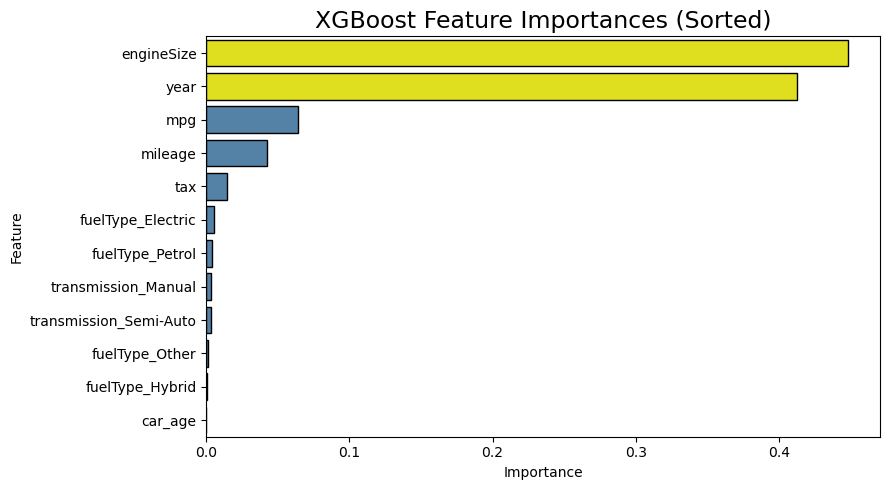

In [67]:
# Sort and plot feature importances
sorted_imp = importances.argsort()[::-1]
col = ['yellow'if i<2 else 'steelblue' for i in range(len(sorted_imp))]
plt.figure(figsize=(9, 5))
sns.barplot(x=importances[sorted_imp], y=X.columns[sorted_imp], palette=col, edgecolor='black')
plt.title("XGBoost Feature Importances (Sorted)", fontsize=17)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [68]:
# For Random Forest model
importances = rf.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


year: 0.2326
mileage: 0.0886
tax: 0.0119
mpg: 0.1164
engineSize: 0.2835
car_age: 0.2581
transmission_Manual: 0.0028
transmission_Semi-Auto: 0.0013
fuelType_Electric: 0.0001
fuelType_Hybrid: 0.0002
fuelType_Other: 0.0001
fuelType_Petrol: 0.0044


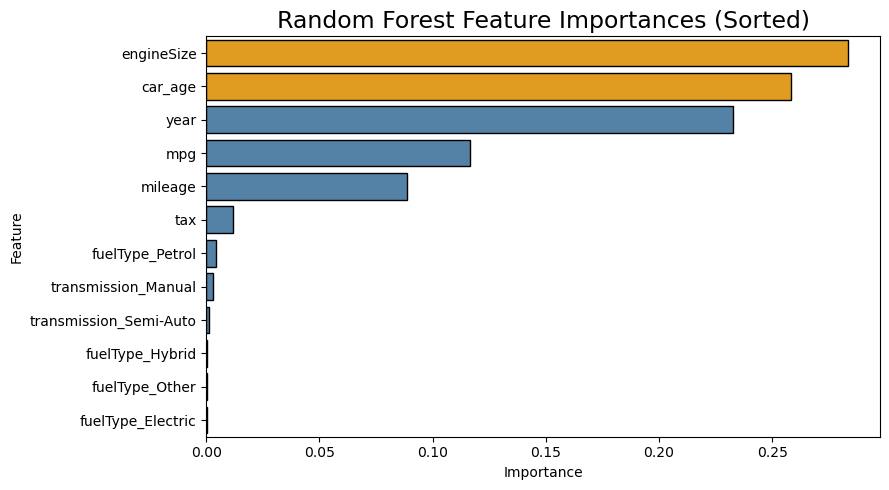

In [87]:
# Sort and plot feature importances
sorted_imp = importances.argsort()[::-1]
col = ['orange'if i<2 else 'steelblue' for i in range(len(sorted_imp))]
plt.figure(figsize=(9, 5))
sns.barplot(x=importances[sorted_imp], y=X.columns[sorted_imp], palette=col, edgecolor='black')
plt.title("Random Forest Feature Importances (Sorted)", fontsize=17)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Comment:
Both relies most heavily on `year` or `car_age` and `engine size` feature.

---

## Residual Analysis

##### For the Random Forest model.

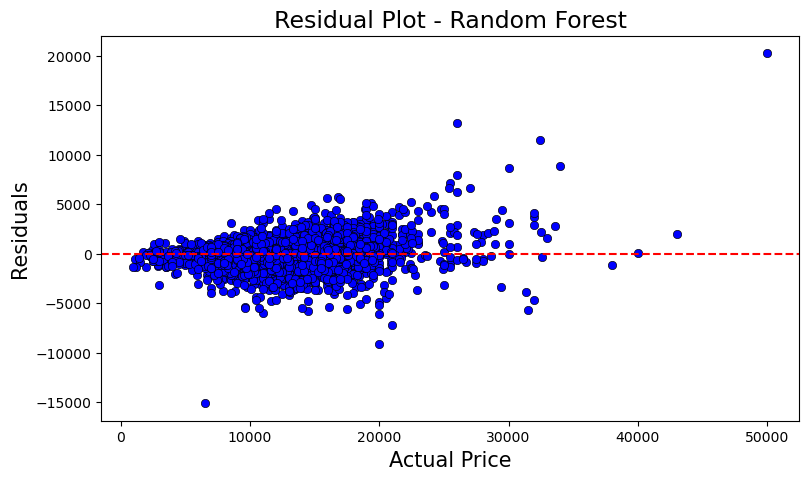

In [71]:
# Computing residuals
residuals_rf = y_test - y_pred_rf

# Creating residual plot
plt.figure(figsize=(9, 5))
sns.scatterplot(x=y_test, y=residuals_rf, color='blue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--') 
plt.title("Residual Plot - Random Forest", fontsize=17)
plt.xlabel("Actual Price", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.show()

Most residuals are centered near zero. Although, there is a slight spread as the actual price increases (*suggestive of faint heteroscedasticity*), the model is predicting used car prices accurately in general.

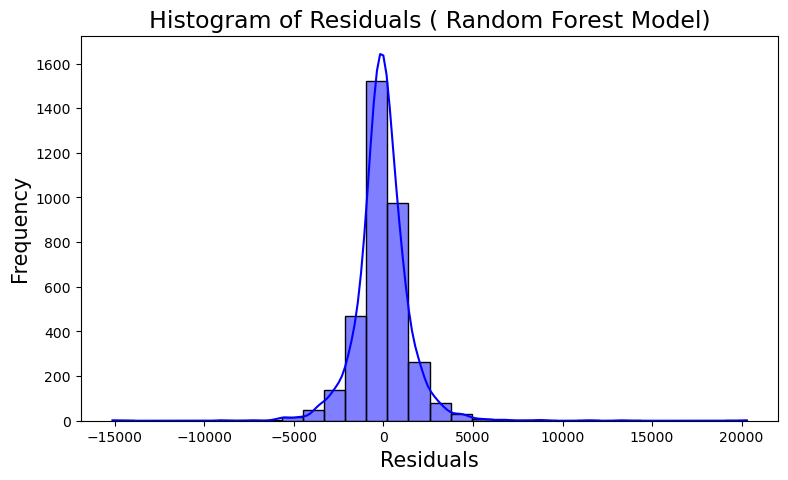

In [72]:
# Creating a histogram for residuals with Kernel Density Estimate (KDE)
plt.figure(figsize=(9, 5))
sns.histplot(residuals_rf, bins=30, kde=True, color='blue', edgecolor='black')
plt.title("Histogram of Residuals ( Random Forest Model)", fontsize=17)
plt.xlabel("Residuals", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()


##### For the XGBoost model.

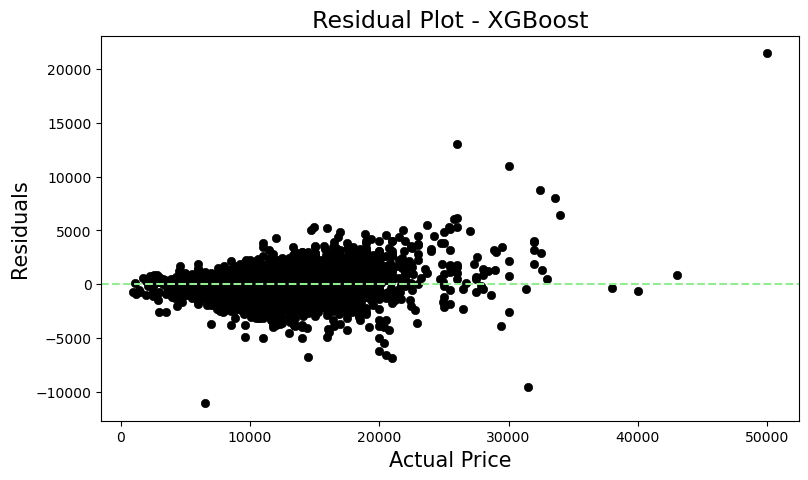

In [83]:
# Computing residuals
residuals_xgb = y_test - y_pred_xgb

# Creating residual plot
plt.figure(figsize=(9, 5))
sns.scatterplot(x=y_test, y=residuals_xgb, color='black', edgecolor='black')
plt.axhline(y=0, color='lightgreen', linestyle='--') 
plt.title("Residual Plot - XGBoost", fontsize=17)
plt.xlabel("Actual Price", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.show()

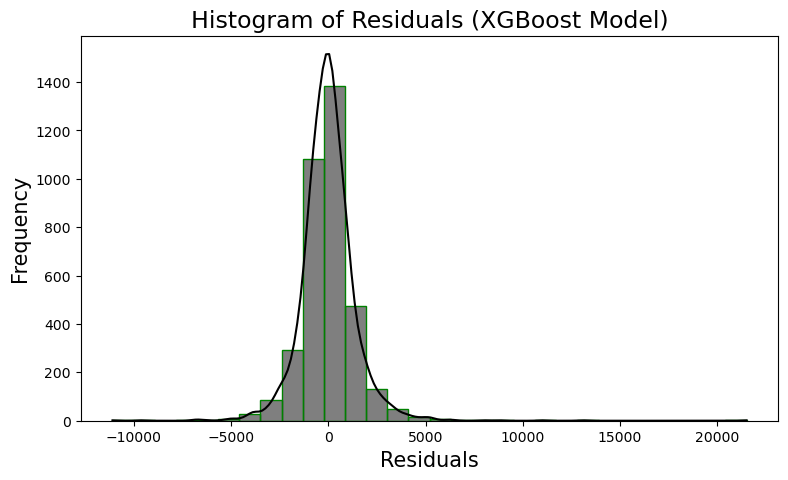

In [81]:
# Creating a histogram for residuals with Kernel Density Estimate (KDE)
plt.figure(figsize=(9, 5))
sns.histplot(residuals_xgb, bins=30, kde=True, color='black', edgecolor='green')
plt.title("Histogram of Residuals (XGBoost Model)", fontsize=17)
plt.xlabel("Residuals", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()


Both XGBoost and Random Forest residuals show similar KDE curves and approximate normality. This suggests that both models are well-calibrated and do not suffer from significant bias.

----------------


<div style="border:2px solid #ccc; border-radius:10px; padding:20px; background:linear-gradient(to right, #f9f9f9, #e0f7fa); box-shadow:2px 2px 10px rgba(0,0,0,0.1); font-family:'Segoe UI', sans-serif;">
  <h1 style="text-align:center; color:#0077b6;">Conclusion</h1>
    
  <p style="font-size:16px; line-height:1.6; color:#333;">
    After exploring multiple regression models, <strong>Random Forest</strong> delivered the strongest performance with minimal bias. Its residuals cluster tightly around zero, even at higher price points, making it a dependable tool for modeling price trends across a wide range of used vehicles.
  </p>
  <p style="font-size:16px; line-height:1.6; color:#333;">
    Transforming the year feature into <code>car_age</code> significantly improved model performance and aligned the model with real-world depreciation trends.
  </p>

  <hr style="border:0; height:1px; background-color:#ddd; margin:20px 0;">
  <h3 style="text-align:center; color:#555;">
    Presented by:
    <a href="https://www.linkedin.com/in/carllegros/" target="_blank" style="color:#0077b6; text-decoration:none;">Carl Legros</a>
  </h3>
</div>

